In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np

print("Starting experiment...")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Hyperparameters
num_epochs = 6
num_classes = 10
batch_size = 100
learning_rate = 0.001

DATA_PATH = 'datasets/'
MODEL_STORE_PATH = 'trained_models/'

# transforms to apply to the data
#trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 10000)
        self.fc2 = nn.Linear(10000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = ConvNet()
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)

Starting experiment...
Epoch [1/6], Step [100/600], Loss: 0.3591, Accuracy: 86.00%
Epoch [1/6], Step [200/600], Loss: 0.1562, Accuracy: 96.00%
Epoch [1/6], Step [300/600], Loss: 0.2355, Accuracy: 91.00%
Epoch [1/6], Step [400/600], Loss: 0.1333, Accuracy: 96.00%
Epoch [1/6], Step [500/600], Loss: 0.0165, Accuracy: 100.00%
Epoch [1/6], Step [600/600], Loss: 0.0611, Accuracy: 98.00%
Epoch [2/6], Step [100/600], Loss: 0.0447, Accuracy: 98.00%
Epoch [2/6], Step [200/600], Loss: 0.0498, Accuracy: 98.00%
Epoch [2/6], Step [300/600], Loss: 0.0521, Accuracy: 99.00%
Epoch [2/6], Step [400/600], Loss: 0.1544, Accuracy: 95.00%
Epoch [2/6], Step [500/600], Loss: 0.1421, Accuracy: 94.00%
Epoch [2/6], Step [600/600], Loss: 0.0607, Accuracy: 98.00%
Epoch [3/6], Step [100/600], Loss: 0.0948, Accuracy: 96.00%
Epoch [3/6], Step [200/600], Loss: 0.0464, Accuracy: 98.00%
Epoch [3/6], Step [300/600], Loss: 0.0373, Accuracy: 98.00%
Epoch [3/6], Step [400/600], Loss: 0.0548, Accuracy: 97.00%
Epoch [3/6], Ste

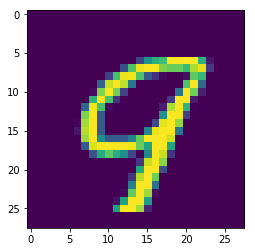

In [46]:
from matplotlib import pyplot as plt
%matplotlib inline

images_np = images.cpu().numpy()
plt.imshow(images_np[18,0])